<a href="https://colab.research.google.com/github/danoAasland/OhioUtilModel/blob/master/cnnPoCmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#notebook localized installs
!pip install seaborn
#some functions from tensorflow_docs
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-025zmfhu
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-025zmfhu
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0-cp36-none-any.whl size=77942 sha256=7e7f4ccfb36da2551434b4c3d391a4c2c8ef6d008ec68933572d847449c3af50
  Stored in directory: /tmp/pip-ephem-wheel-cache-mj7rq35c/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [2]:
#maintains python 2/3 compatibility
from __future__ import absolute_import, division, print_function, unicode_literals

#installs packages
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

#needed to import files into CoLab notebook
from google.colab import files
import io

#set graphs to plot within env
%matplotlib inline
#set style of graphs
sns.set(rc={'figure.figsize':(12, 6)})
plt.style.use('fivethirtyeight')

TensorFlow 2.x selected.


In [4]:
#run this cell to open a file viewer to select a file to upload, rerun as needed to upload new files
uploaded = files.upload()

Saving mergeCleCinSave.csv to mergeCleCinSave.csv


In [0]:
#data import and save as dataframe to variable name 'dataset'
dataset = pd.read_csv(io.BytesIO(uploaded['mergeCleCinSave.csv']))

In [6]:
dataset.head()

,SF,Floors,Year Built,Value,E annual,G annual,Estimated Savings
0,910,1.5,1900.0,22300.0,8376.0,1370.0,543.0
1,942,2.0,1916.0,56300.0,8944.0,841.0,543.0
2,1152,2.0,1941.0,71300.0,8717.0,1049.0,543.0
3,1236,1.5,1941.0,75000.0,5803.0,894.0,543.0
4,2950,2.0,1920.0,216800.0,5874.0,2563.0,616.0


In [7]:
#shows count of rows and columns
dataset.shape

(164, 7)

In [0]:
#Set a min. threshold annual electrical value of 6750
#based on avg. monthly 750.0 KwH x 12 months = 9000.0 annual
#less +/- 25% = 2250.0, 9000.0 - 2250.0 = 6750.0

#dataset = dataset.loc[dataset['E annual'] > 6750].copy()

In [0]:
#Set a min. threshold home value of 100k, want to eliminate
#homes with low probability for having disp. income
# = dataset.loc[dataset['Value'] > 100000].copy()

In [0]:
#only uncomment when you are running a LARGE dataset through here
#this creates a 10% sample pop. dataset to test with to minimize
#tuning time waiting for model to converge

#dataset = dataset.sample(frac=0.1,random_state=0, axis=0)

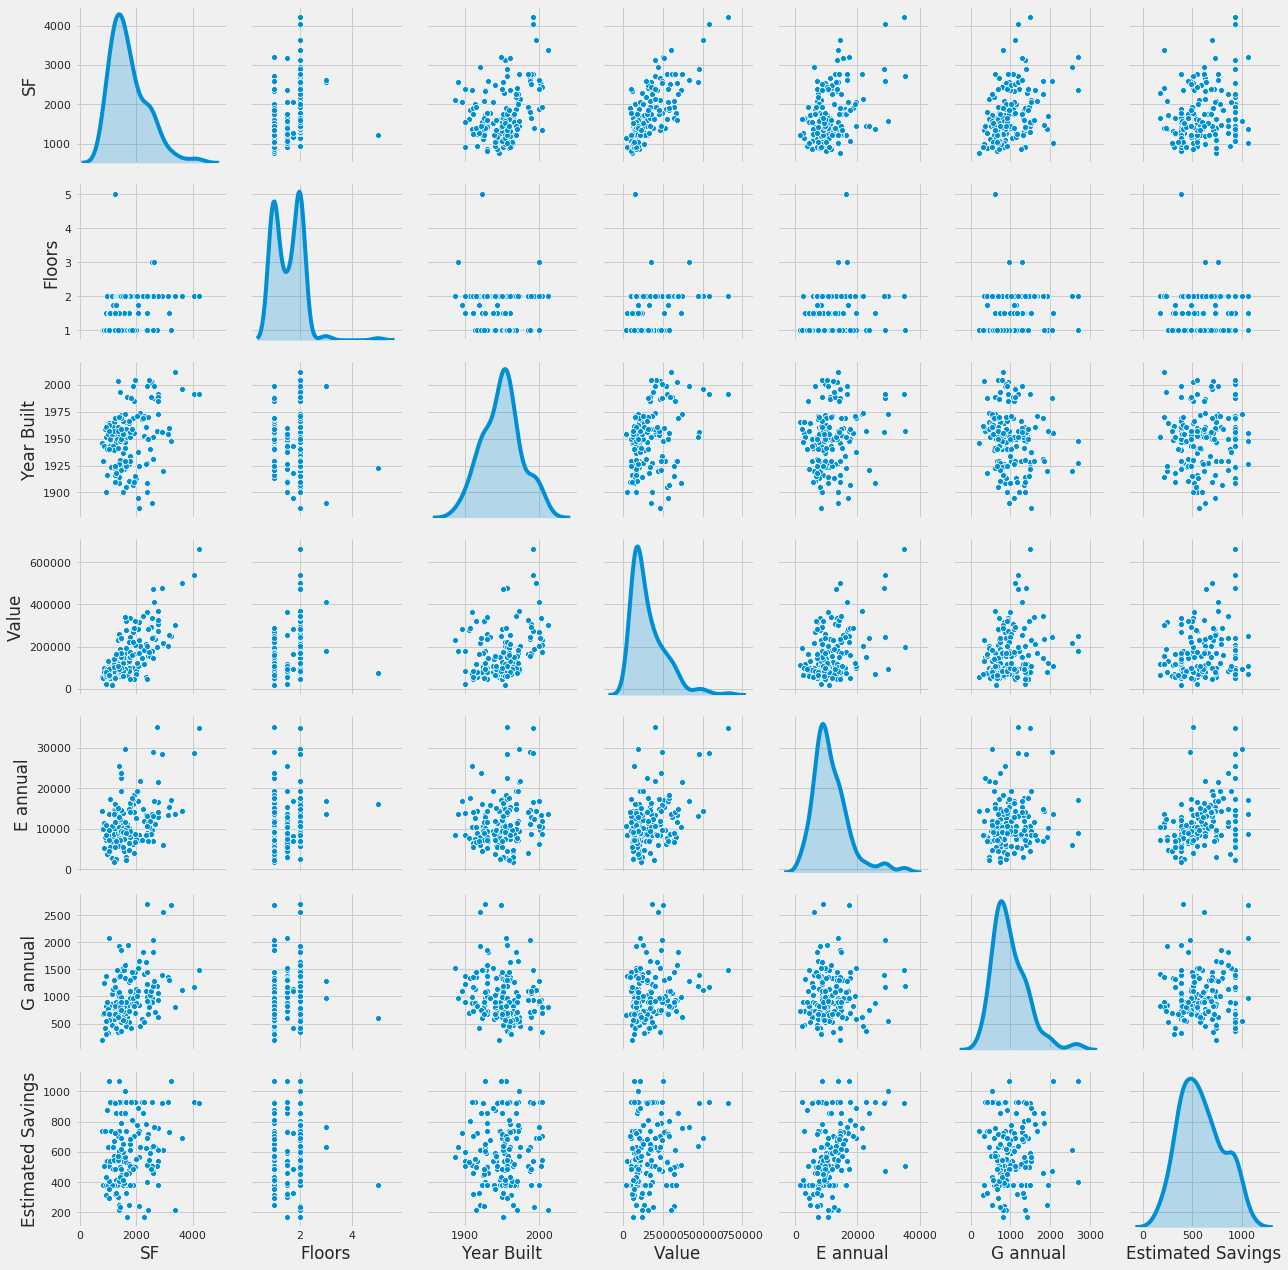

In [59]:
sns.pairplot(dataset, diag_kind="kde")

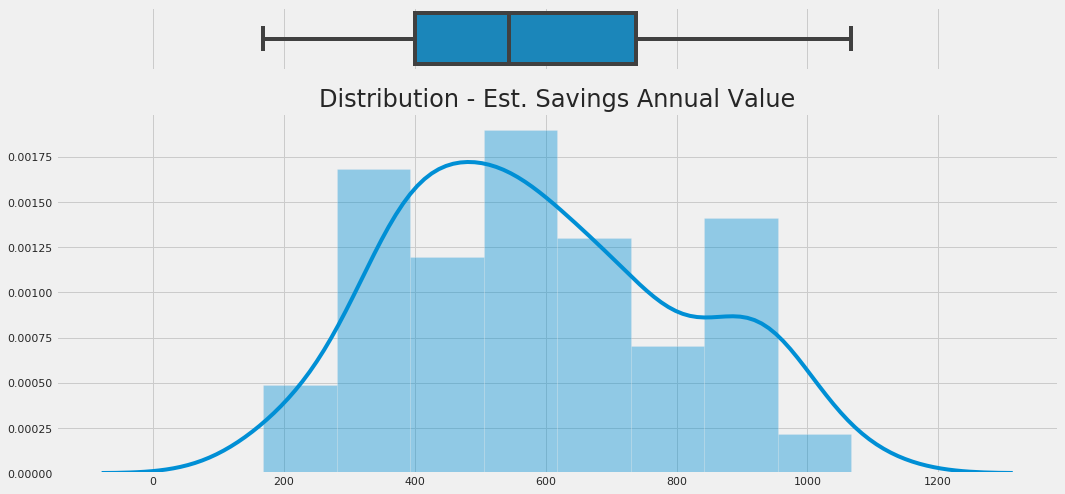

In [60]:
#more in-depth plot to easily identify outliers and visualize trend
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, figsize=(16, 8), gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(dataset['Estimated Savings'], ax=boxplot)
sns.distplot(dataset['Estimated Savings'], ax=histogram)
boxplot.set(xlabel='')
plt.title('Distribution - Est. Savings Annual Value', fontsize=24)
plt.xlabel('');

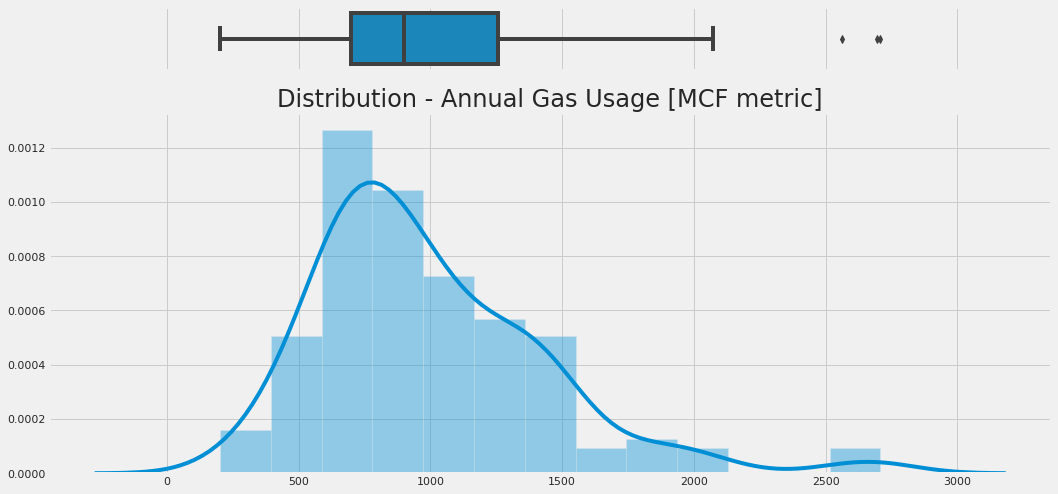

In [61]:
#more in-depth plot to easily identify outliers and visualize trend
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, figsize=(16, 8), gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(dataset['G annual'], ax=boxplot)
sns.distplot(dataset['G annual'], ax=histogram)
boxplot.set(xlabel='')
plt.title('Distribution - Annual Gas Usage [MCF metric]', fontsize=24)
plt.xlabel('');

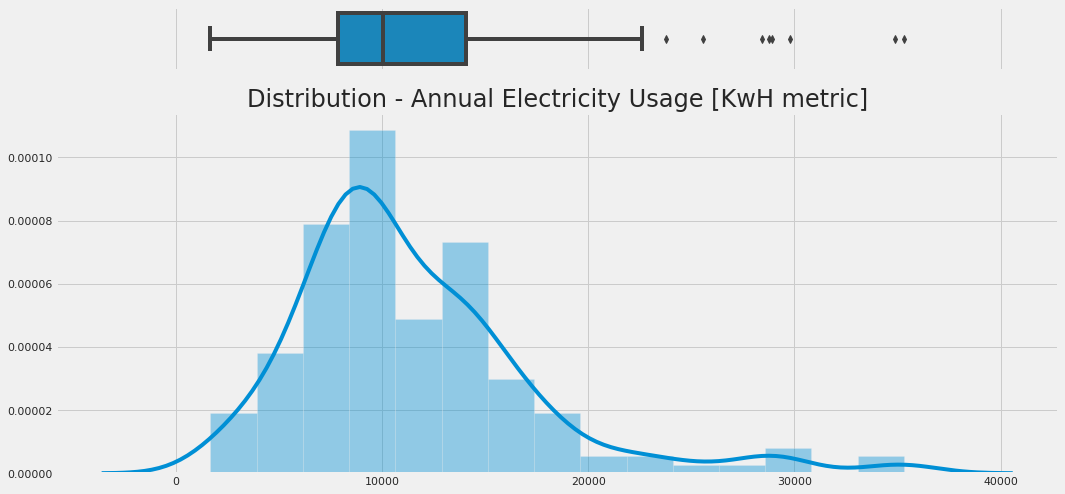

In [62]:
#more in-depth plot to easily identify outliers and visualize trend
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, figsize=(16, 8), gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(dataset['E annual'], ax=boxplot)
sns.distplot(dataset['E annual'], ax=histogram)
boxplot.set(xlabel='')
plt.title('Distribution - Annual Electricity Usage [KwH metric]', fontsize=24)
plt.xlabel('');

In [0]:
#split dataset into train and test sets
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [16]:
#visualize basic stats on data
train_stats = train_dataset.describe()

#change to match whatever target variable in your dataset
train_stats.pop("Estimated Savings")

train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
SF,131.0,1760.374046,686.165447,768.0,1259.0,1542.0,2267.0,4224.0
Floors,131.0,1.566794,0.579974,1.0,1.0,1.5,2.0,5.0
Year Built,131.0,1951.038168,25.480733,1886.0,1934.0,1952.0,1964.5,2012.0
Value,131.0,159157.938931,113195.091275,17900.0,81350.0,117900.0,200285.0,661830.0
E annual,131.0,11701.015267,6007.290248,1664.0,8323.5,10128.0,14121.0,35314.0
G annual,131.0,1009.442748,453.454097,201.0,689.5,905.0,1307.0,2708.0


In [0]:
#save target values for train and test and remove from feature dataset
train_labels = train_dataset.pop('Estimated Savings')
test_labels = test_dataset.pop('Estimated Savings')

In [0]:
#normalizes data to dist. as derived from training data mean and standard dev.

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

In [0]:
#create train and test datasets that are normalized
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [0]:
#convolutional neural net model function
#Hyperparameter tuning done here
#uncomment a 'layer.Dense' line to add a layer
#comment to remove, experiment with to find optimal depth
# percent of nodes are turned off randomly using 'Dropout', set value between (0.0-1.0), 0.5 = 50% nodes off

def build_model():
  model = keras.Sequential([
    #layers.Dense(256, activation='relu', input_shape=[len(train_dataset.keys())]),
    #uncomment to start with 128 node network, make sure to comment out layers to match this start value, e.g. next layer = 64 nodes
    #layers.Dense(128, activation='relu', input_shape=[len(train_dataset.keys())]),
    #uncomment to start with 64 node network, make sure to comment out layers to match this start value, e.g. next layer = 32 nodes
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    #layers.Dropout(0.5),
    #layers.Dense(256, activation='relu'),
    #layers.Dropout(0.1),
    #layers.Dense(128, activation='relu'),
    #layers.Dropout(0.1),
    layers.Dense(64, activation='relu'),
    #layers.Dropout(0.1),
    layers.Dense(32, activation='relu'),
    #layers.Dropout(0.1),
    layers.Dense(16, activation='relu'),
    #layers.Dropout(0.1),
    layers.Dense(8, activation='relu'),
    #layers.Dense(4, activation='relu'),
    #layers.Dense(2, activation='relu'),
    layers.Dense(1) #always leave this last to return a single output value
  ])

  #two main types of optimizers for regression models, uncomment one to run
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  #optimizer = tf.keras.optimizers.Adam(lr=0.001)

  model.compile(loss='mean_squared_logarithmic_error',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [0]:
#builds model framework and assigns to var name 'model'
model = build_model()

In [46]:
#visualizes model structure
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_22 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_23 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 9         
Total params: 7,361
Trainable params: 7,361
Non-trainable params: 0
____________________________________________________

In [47]:
#small, 10 rows, test data to ensure everything works before we train/test/valid. model
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
#shows output of test run
example_result

array([[ 0.02269659],
       [ 0.093803  ],
       [ 0.05559907],
       [-0.0520892 ],
       [-0.04357175],
       [ 0.06393176],
       [ 0.03286485],
       [-0.03515122],
       [ 0.00465201],
       [ 0.03719655]], dtype=float32)

In [48]:
#set epochs between (min) 1 and (max) size of data
EPOCHS = 1000

#this model trains without any early stopping, continues
#until all epochs run

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:39.6959,  mae:613.3058,  mse:422541.6875,  val_loss:35.0356,  val_mae:488.0280,  val_mse:258912.2656,  
....................................................................................................
Epoch: 100, loss:0.1238,  mae:158.7466,  mse:42675.2852,  val_loss:0.1947,  val_mae:172.1471,  val_mse:62303.0273,  
....................................................................................................
Epoch: 200, loss:0.1086,  mae:146.1551,  mse:36374.1328,  val_loss:0.1816,  val_mae:161.7811,  val_mse:63439.1953,  
....................................................................................................
Epoch: 300, loss:0.1006,  mae:140.3446,  mse:34638.1758,  val_loss:0.2139,  val_mae:190.1821,  val_mse:82096.6875,  
....................................................................................................
Epoch: 400, loss:0.0928,  mae:135.2718,  mse:31158.6836,  val_loss:0.2012,  val_mae:179.6332,  val_mse:78000.2656,  
........

In [49]:
#visualize the loss/error values for training and validation data
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.031821,80.276329,12514.223633,0.324277,259.612915,142690.890625,995
996,0.031216,77.971367,12351.213867,0.308012,240.797852,125457.234375,996
997,0.035019,83.762810,14234.517578,0.338134,270.529266,154472.609375,997
998,0.033015,80.532883,13022.232422,0.314948,250.073273,132481.796875,998
999,0.033065,80.889488,13505.654297,0.318019,252.664841,134181.281250,999


In [0]:
#set plot, smooth to 2 standard deviations
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE - Target Value')

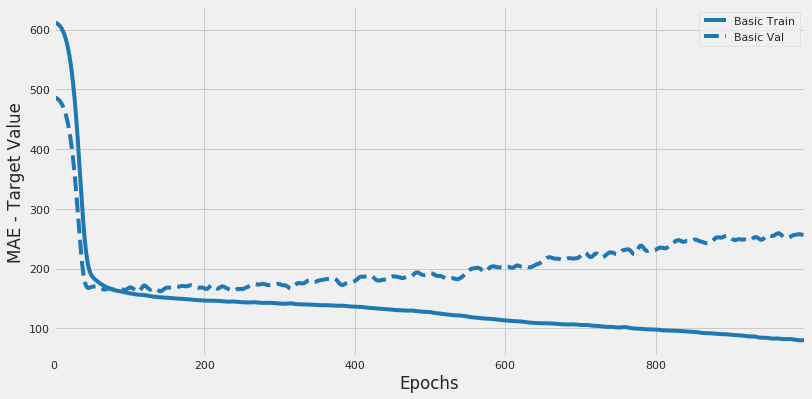

In [51]:
#plots mean actual error value for train and test accross all epochs("runs" through data)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE - Target Value')

Text(0, 0.5, 'MSE Target Value Squared')

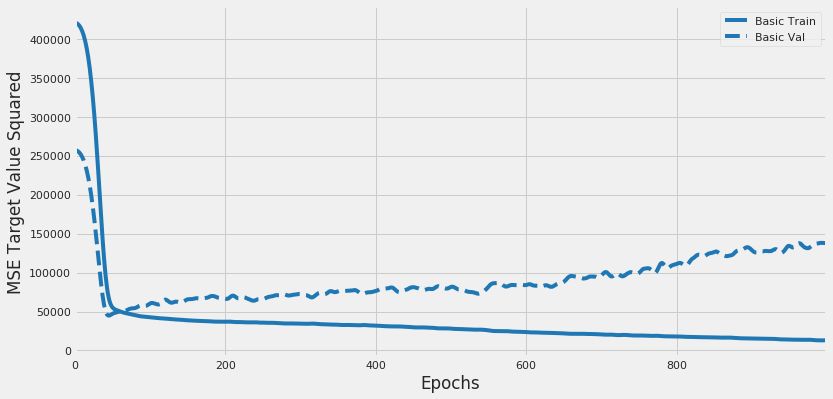

In [52]:
#plots mean squared error value for train and test accross all epochs("runs" through data)
#penalizes more severely for getting a predict wrong by a large margin
plotter.plot({'Basic': history}, metric = "mse")
plt.ylabel('MSE Target Value Squared')

In [53]:
#Testing model with early stopping parameter
#finds a given best value for monitored loss and if doesn't improve by set tries it stops
#and returns that best model weights for the input variables

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:39.7942,  mae:613.3055,  mse:422535.3750,  val_loss:34.7438,  val_mae:487.9906,  val_mse:258870.1875,  
....................................................................................................
Epoch: 100, loss:0.1254,  mae:160.7750,  mse:42448.4531,  val_loss:0.1931,  val_mae:165.7709,  val_mse:65602.6328,  
....................................................................................................
Epoch: 200, loss:0.1088,  mae:146.3940,  mse:36832.0547,  val_loss:0.2082,  val_mae:176.2727,  val_mse:77375.5625,  
........................................

Text(0, 0.5, 'MAE Target Value')

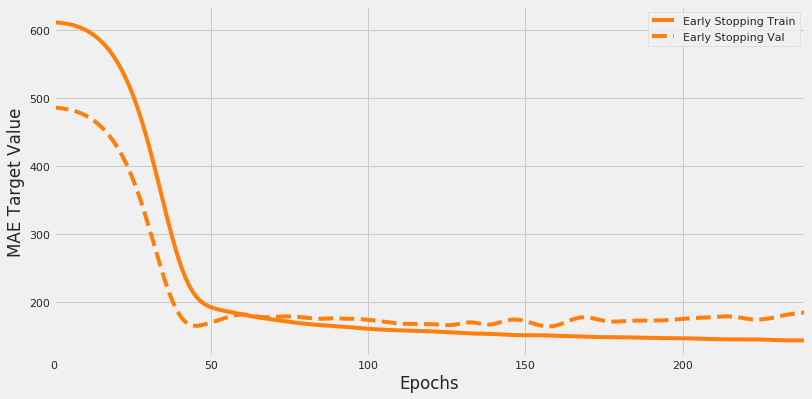

In [54]:
#plots mean actual error value for train and test accross all epochs("runs" through data)
#for early stopping model

plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylabel('MAE Target Value')

In [55]:
#saves models loss value, mae value, and mse value
#prints values with epoch run value, focus is absolute average error
#for each data point as a average of total
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} ".format(mae))

33/33 - 0s - loss: 0.2159 - mae: 198.1877 - mse: 65282.5156
Testing set Mean Abs Error: 198.19 


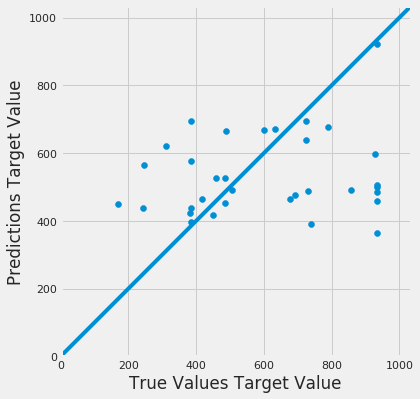

In [56]:
#plots predicted values, line represents "perfect" prediction trace
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values Target Value')
plt.ylabel('Predictions Target Value')
lims = [0, (test_labels.max() + 100)]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

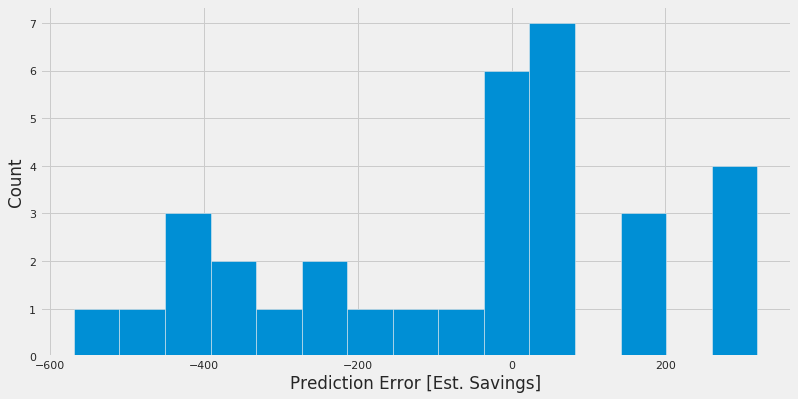

In [58]:
#plots the distribution of errors and there value they
#were "off by" versus actual value
error = test_predictions - test_labels
plt.hist(error, bins = 15)
plt.xlabel("Prediction Error [Est. Savings]")
_ = plt.ylabel("Count")